# Urban Pollution Island in Aburrá Valley: A Final Project for TalentoTech

Integrants:
- Guiller Alexis Ayala Parra
- Juan Manuel
- Luis
- Sara

Data used for this final project was supplied by SIATA (Early Warning System of Medellín and Aburrá Valley) which operates one of the hugest hydrometeorological and air pollution network in Colombia.

# Data preprocessing

## PM2.5 concentration data

1. Concatenate: Data supplied by SIATA are organized in several CSV files for each year. So we have to concatenate the data in a single dataframe to start to preprocess it.

In [1]:
import numpy as np
import pandas as pd

from glob import glob

In [2]:
dir_csv_pm25 = './csv/raw_data/*PM25*.csv'
list_dir_csv_pm25 = sorted(glob(dir_csv_pm25))

In [3]:
list_dfs = list()
for dir_csv in list_dir_csv_pm25:
    df = pd.read_csv(dir_csv, index_col=[0], parse_dates=[0])
    list_dfs.append(df)

df_ncc_pm25 = pd.concat(list_dfs)

2. Remove outlier values: The low-cost sensor are less accurate than official equipments. Therefore, low-cost are susceptible to unrealistic measurements of PM2.5 concentrations. So, maximum valid PM2.5 concentration that we considered was 120 $\mu g/m^{3}$, as this miximun concentration was measured in march 2016 and Decemeber holidays by the official air quality network.

In [4]:
df_ncc_pm25[df_ncc_pm25 > 120] = np.nan

3. Remove low-cost sensors that have little data: We have hourly concentration PM2.5 data since January 01, 2018 to Abril 07, 2025 for a total of 345 low-cost sensors. So, if all sensors never failed, the total possible measurements would be of 63696. However, the real world the low-cost sensors tend to fail more often than an official air quality instrument. Consequently, we have decided to be so flexible and will work with all sensors that have at least the 25% data available.

In [5]:
date_range = pd.date_range(start='2018-01-01 00:00', end='2025-04-07 23:00', freq='1h')
total_hours = date_range.size

total_hourly_measurements = df_ncc_pm25.describe().loc['count']

percent_covered_time = total_hourly_measurements*100/total_hours

total_hourly_measurements.min()*100/total_hours, total_hourly_measurements.max()*100/total_hours

(0.0, 90.70428284350666)

The sensor with the lowest number of measurements for the time period had 0 concentration data, meaning that this sensor never measured a valid PM2.5 concentration. On the other hand, the best sensor took 57775 valid concentration data, which correspond to a 90 % of the time covered.

In [6]:
valid_sensors = percent_covered_time[percent_covered_time >= 25].index.to_list()
df_ncc_pm25 = df_ncc_pm25[valid_sensors]

len(valid_sensors), 345, len(valid_sensors)*100/345

(261, 345, 75.65217391304348)

Afterward this step, we are going to work with a total of 261 sensors, which correspond to the 75.6 % of the total of sensors. We consider with this amount of sensors are enough to cover all Aburrá Valley.

In [7]:
df_ncc_pm25.to_csv('./csv/clean_data/NCC_PM25_concentration.csv')

Finally, SIATA provied to us the location of each low-cost sensors. However, we need to filter this kind of data because we aren't to work with all sensors.

In [8]:
location_data = pd.read_csv('./csv/raw_data/coordenadas_nubes_ciudadanos_cientificos.csv', index_col=[0])

numb_nubes = df_ncc_pm25.columns.to_list()
location_data.loc[numb_nubes].to_csv('./csv/clean_data/locations_NCC.csv')

## Metro users

The next python code read Metro's data about the number of users that took the metro system in the time period set between 2019 and 2024. Likewise, the data was organized into an hourly time series and saved to a CSV file.

In [1]:
import pandas as pd

In [2]:
def clean_METRO_table(url, index=1, typeDate="str"):
    """
    Return the METRO DE MEDELLIN DATA clean
    """
    data = pd.read_excel(url, header=index)
    data.rename(columns={'Unnamed: 0': 'dia', 'Unnamed: 1': 'linea_de_servicio'}, inplace=True)

    if typeDate == "str":
      # Intenta parsear automáticamente
      try:
          data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], format="%Y-%m-%d")
      except:
          try:
              data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], format="%d.%m.%Y")
          except:
              # Último intento con inferencia automática (menos confiable)
              data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], dayfirst=True, errors='coerce')
    else:
      data['dia'] = pd.to_datetime(data['dia'], origin='1899-12-30', unit='D')


    data.fillna(0, inplace=True)

    return data

In [3]:
urls = [
    r"https://www.arcgis.com/sharing/rest/content/items/fd593b3c32514d6dade05fb1c79f13b2/data", # 2019
    r"https://www.arcgis.com/sharing/rest/content/items/275ff205ea564ee9963210c0923dce81/data",
    r"https://www.arcgis.com/sharing/rest/content/items/1e5e1bb004944971a57fa2847137d9f0/data",
    r"https://www.arcgis.com/sharing/rest/content/items/4c66112ec6d045f29f7ad2cbffe06cc2/data",
    r"https://www.arcgis.com/sharing/rest/content/items/569c4b4c1ad54c3da95aa5f195637db2/data",
    r"https://www.arcgis.com/sharing/rest/content/items/666bac2214f445a18227f16cf8426faf/data"
]

In [ ]:
table_metro = pd.concat([
    clean_METRO_table(urls[0], 2),
    clean_METRO_table(urls[1], 2),
    clean_METRO_table(urls[2], 2, "int"),
    clean_METRO_table(urls[3], 1),
    clean_METRO_table(urls[4], 1),
    clean_METRO_table(urls[5], 1)
    ])

table_metro["linea_de_servicio"] = table_metro["linea_de_servicio"].astype(str).str.upper()
table_metro.set_index('dia', inplace=True)

In [54]:
list_series = list()
list_dates  = table_metro.index.date.tolist()
for date in list_dates:
    hourly_serie = table_metro.loc[str(date)].sum().drop(['linea_de_servicio', 'Total general (Número de pasajeros)'])
    hourly_serie.index = pd.to_datetime(str(date) + ' ' + hourly_serie.index.astype(str))

    list_series.append(hourly_serie)

serie_hourly_metro_users = pd.concat(list_series)

In [59]:
serie_hourly_metro_users.to_csv('./csv/clean_data/Hourly_TS_metro_users.csv')

# Data postprocessing

## Particulate matter PM2.5

In [9]:
import numpy as np
import pandas as pd
import cartopy as ctp
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from calendar import month_abbr, month_name
from locale import setlocale, LC_TIME

setlocale(LC_TIME, 'es_CO.UTF-8')

/home/guiayala/py_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


'es_CO.UTF-8'

In [10]:
dir_csv = './csv/clean_data/NCC_PM25_concentration.csv'
df_ncc_pm25 = pd.read_csv(dir_csv, index_col=[0], parse_dates=[0])

dir_csv_location = './csv/clean_data/locations_NCC.csv'
df_location = pd.read_csv(dir_csv_location, index_col=[0])

shape_amva = gpd.read_file('./shapefiles/AMVA_boundary.shp')
shape_municipalities = gpd.read_file('./shapefiles/AMVA_municipios.shp')
mask_amva = np.loadtxt('./csv/clean_data/amva_mask.txt')

mask_amva = np.where(mask_amva == 0, False, True)
mask_amva = pd.DataFrame(mask_amva)

In [11]:
def maps(df_anml, vmin=-8, vmax=8, CD=True):
    timestamp = df_anml.index.to_list()
    for i, time in enumerate(timestamp):
        deltat_serie = df_anml.loc[time]

        deltat_serie.name = 'PM2.5'
        deltat_df = pd.concat([deltat_serie.to_frame(), df_location], axis=1)

        x = deltat_df['longitud'].values
        y = deltat_df['latitud'].values
        c = deltat_df['PM2.5'].values

        idx = c.argsort()
        x = x[idx]
        y = y[idx]
        c = c[idx]

        fig, ax = plt.subplots(facecolor='w', figsize=(6, 6), subplot_kw=dict(projection=ctp.crs.PlateCarree()))

        sc = ax.scatter(x=x, y=y, c=c, cmap='BrBG_r', vmin=vmin, vmax=vmax)
        shape_municipalities.boundary.plot(color='k', linewidth=1.5, alpha=1., ax=ax)

        if CD:
            title = f'Hora del día: {str(time).zfill(2)}:00'
            text = 'CD'
        else:
            title = f'Mes del año: {month_name[time]}'
            text = 'CA'
            
        ax.set_title(title, fontsize=18)

        cax = plt.axes([0.65, 0.15, .025, .4])
        cbar = fig.colorbar(sc, cax=cax, extend='both')
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks(np.arange(vmin, vmax+.5, 4))
        cbar.ax.set_ylabel(r'PM2.5 [$\mu g/m^3$]', fontsize=18)

        ax.axis('off')
        
        fig.tight_layout()

        num = str(i).zfill(2)
        fig.savefig(f'./figures/maps/{text}_{num}.png', format='png', bbox_inches='tight')


def creating_animation(pathname, textsave='gif'):
    dir_pngs = sorted(glob(pathname))

    frames = [Image.open(png) for png in dir_pngs]
    frame_one = frames[0]
    frame_one.save(f'./figures/{textsave}.gif', format="GIF", append_images=frames, save_all=True, duration=450, loop=0)

### Diurnal cycles

In [12]:
df_ncc_pm25['hour'] = df_ncc_pm25.index.hour
HDC = df_ncc_pm25.groupby(by='hour').mean()

df_ncc_pm25.drop(columns='hour', inplace=True)

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

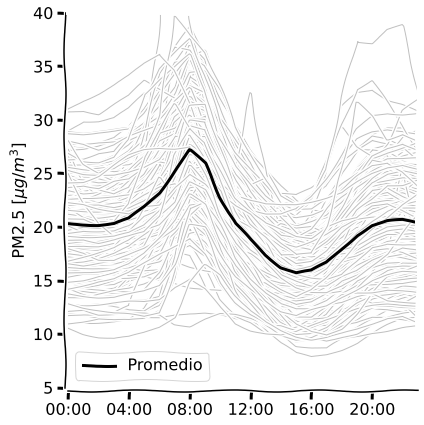

In [ ]:
with plt.xkcd():
    fig, ax = plt.subplots(facecolor='w', figsize=(6, 6))

    ax.plot(HDC, color='silver', linewidth=1.)
    ax.plot(HDC.mean(axis=1), color='k', linewidth=3., label='Promedio')

    ax.set_xticks(range(0, 24, 4))
    ax.set_xticklabels([str(h).zfill(2)+':00' for h in range(0, 24, 4)])

    ax.set_xlim(0, 23)
    ax.set_ylim(5, 40)

    ax.set_ylabel(r'PM2.5 [$\mu g/m^3$]', fontsize=16)

    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('k')
    ax.tick_params(axis='both', which='both', colors='k', labelsize=16)

    ax.spines.bottom.set_position(('axes', -.01))
    ax.spines.left.set_position(('axes', -.01))

    ax.legend(fontsize=16)

    fig.tight_layout()

#### Maps

In [14]:
hourly_annm = HDC - HDC.mean()

/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so

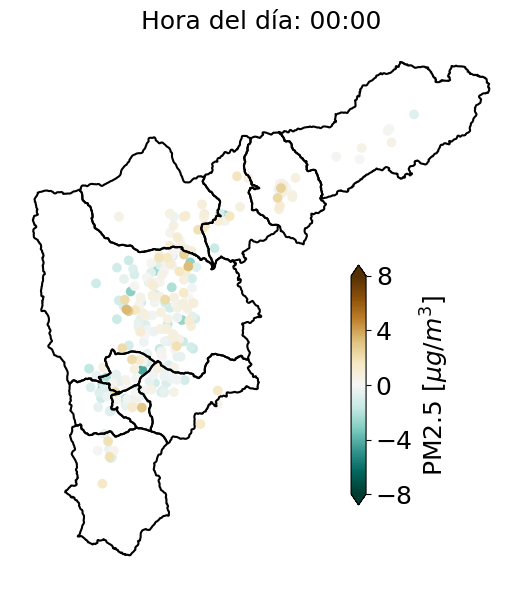

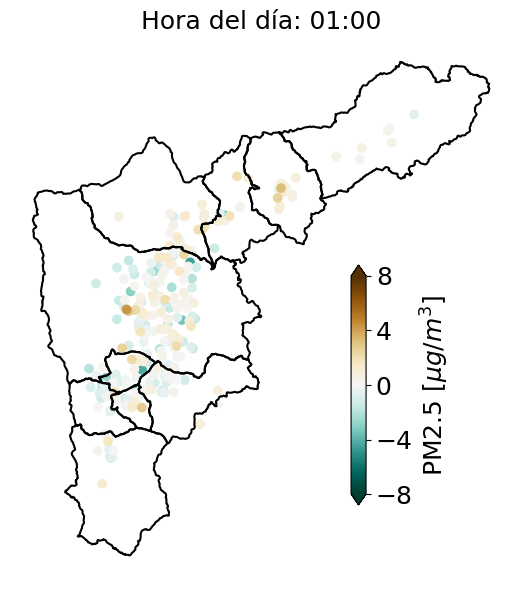

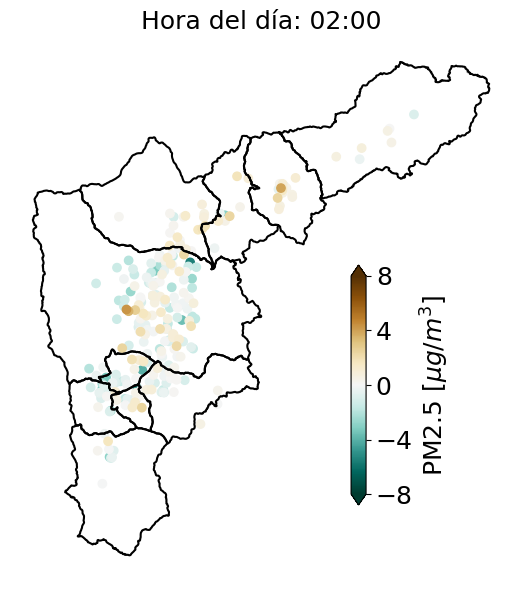

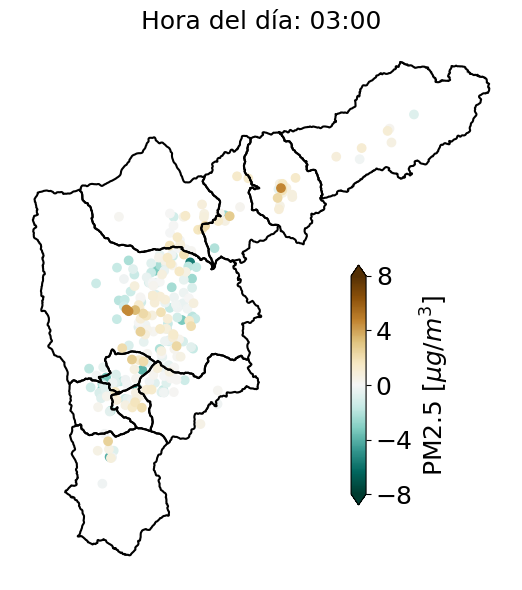

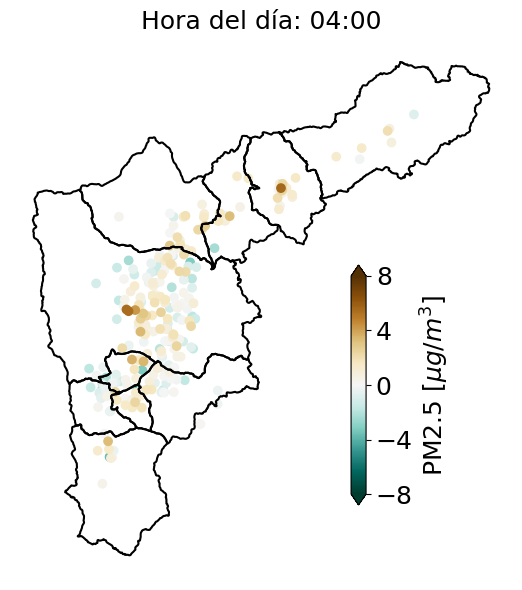

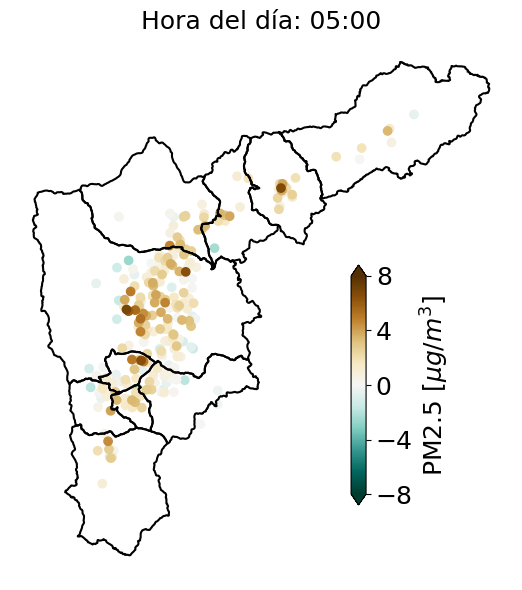

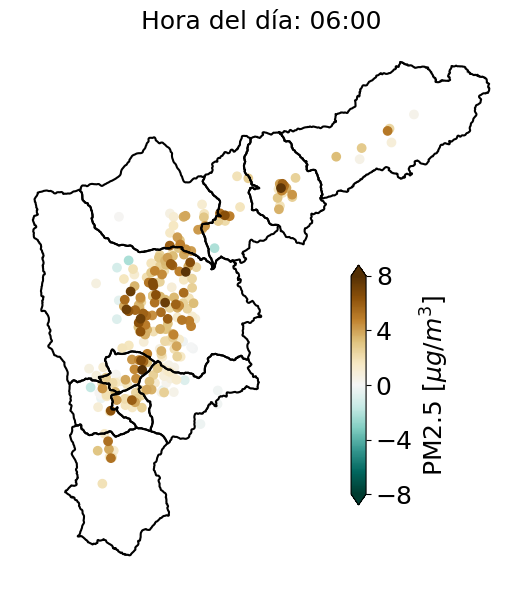

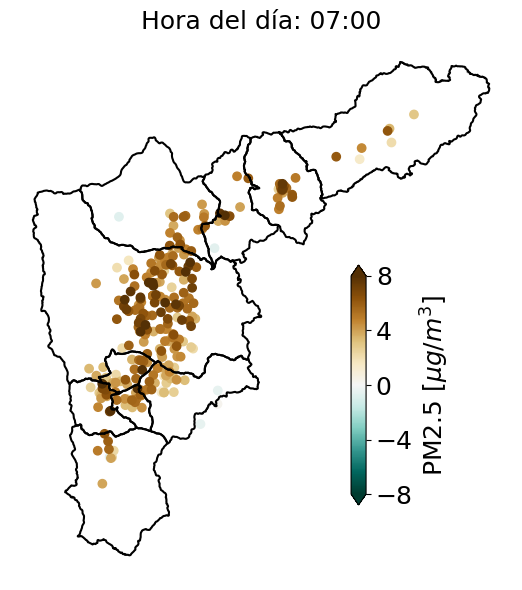

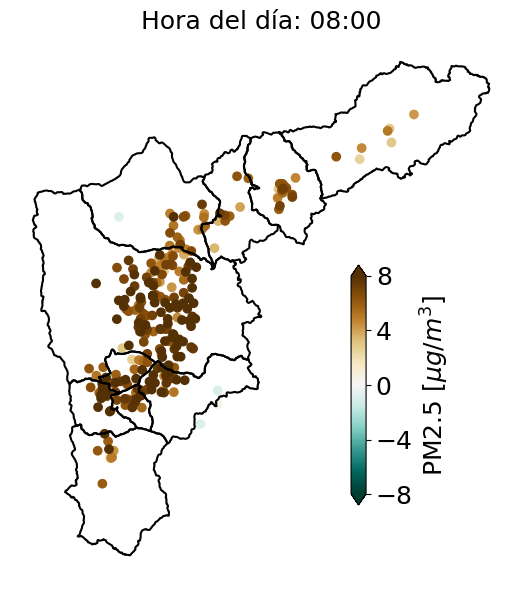

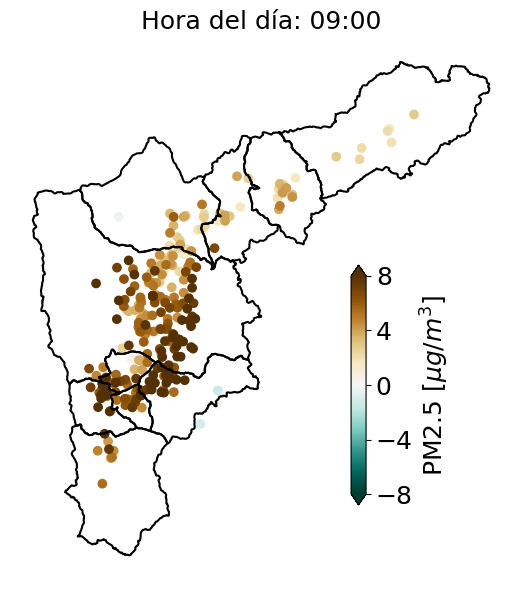

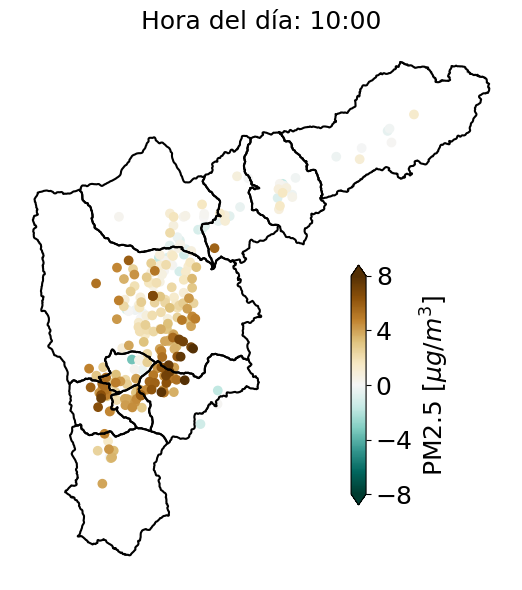

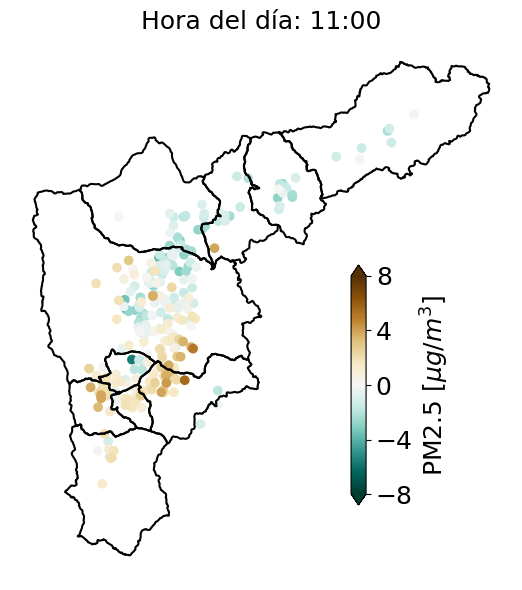

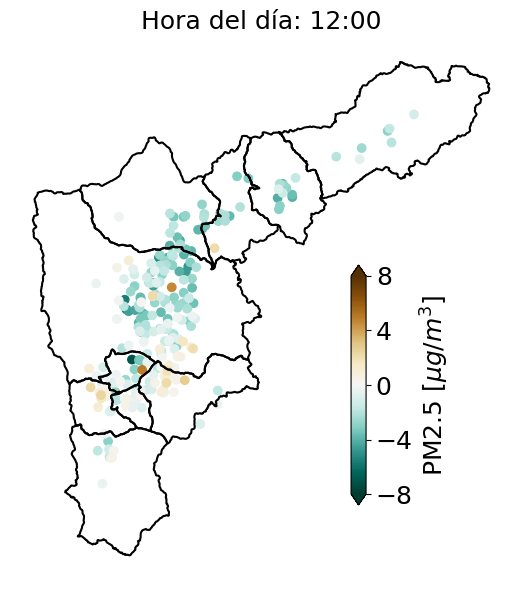

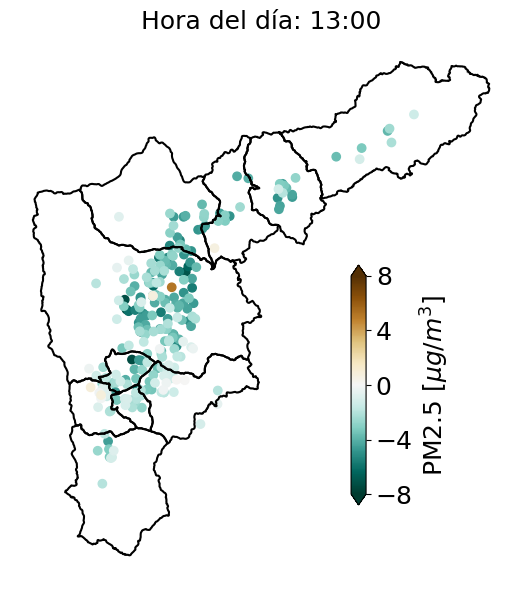

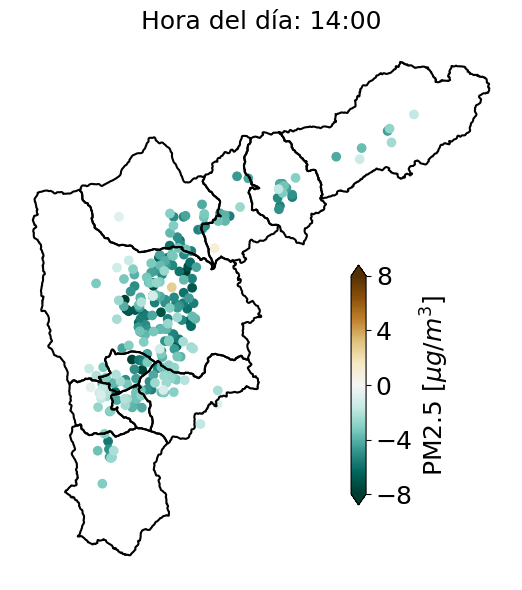

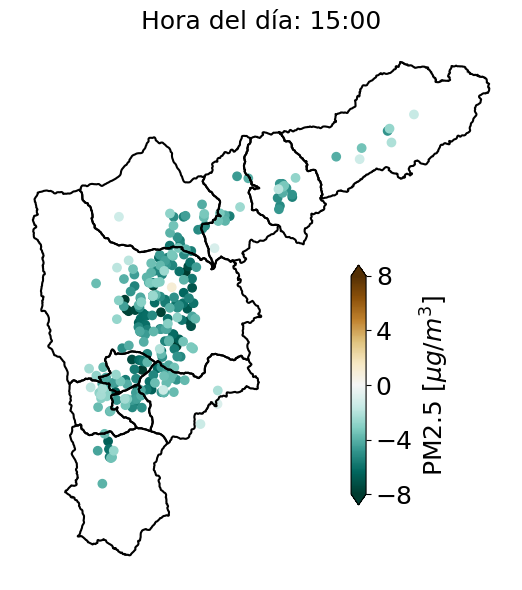

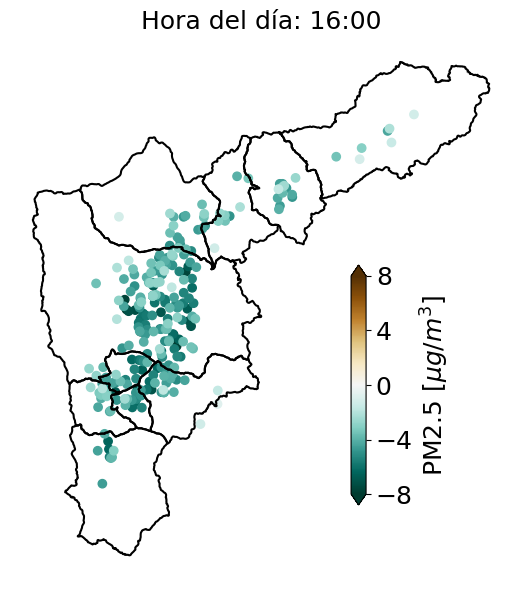

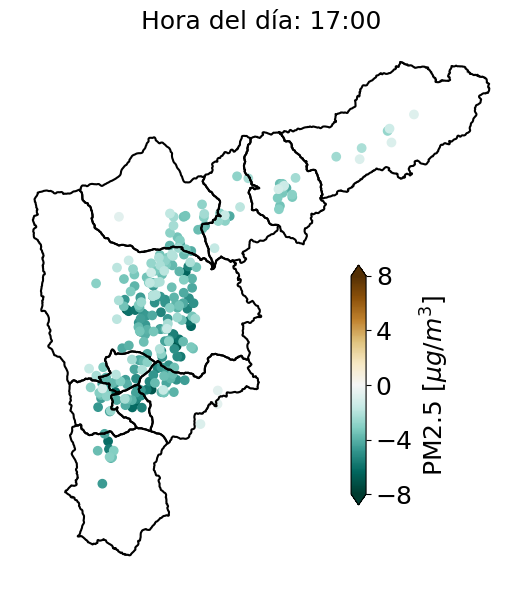

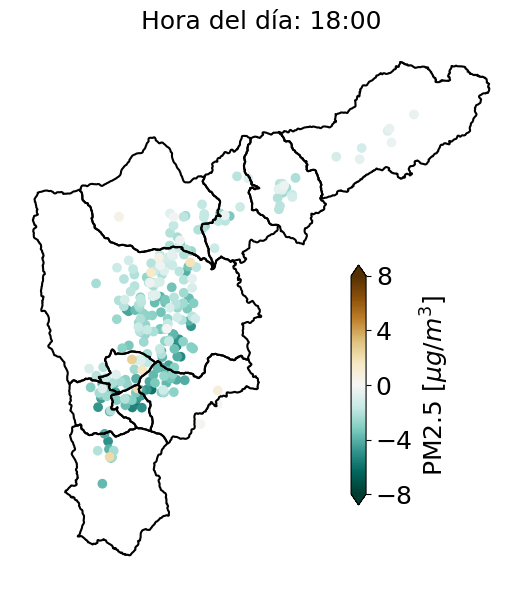

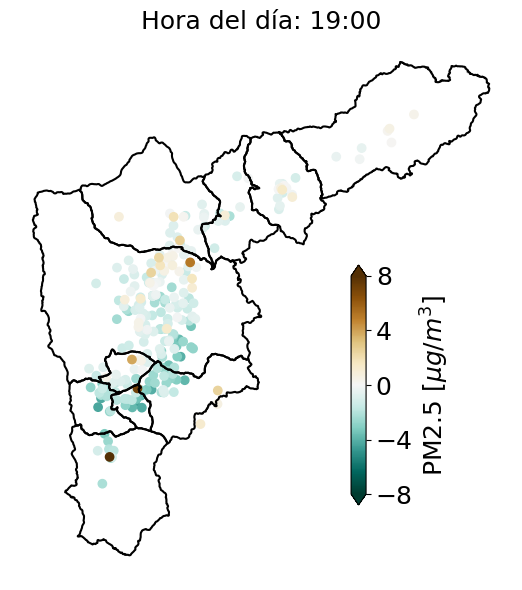

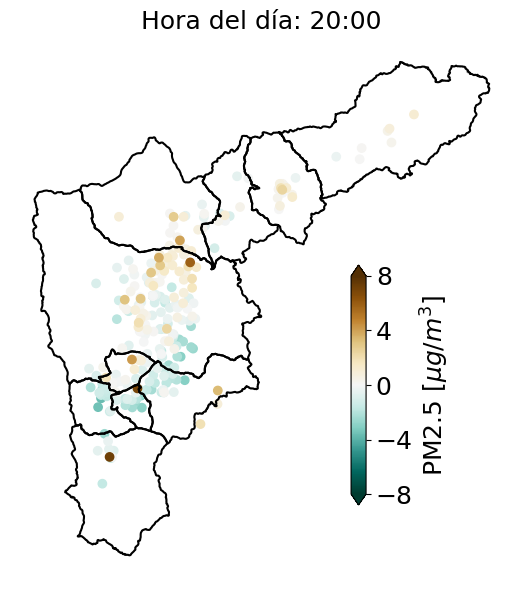

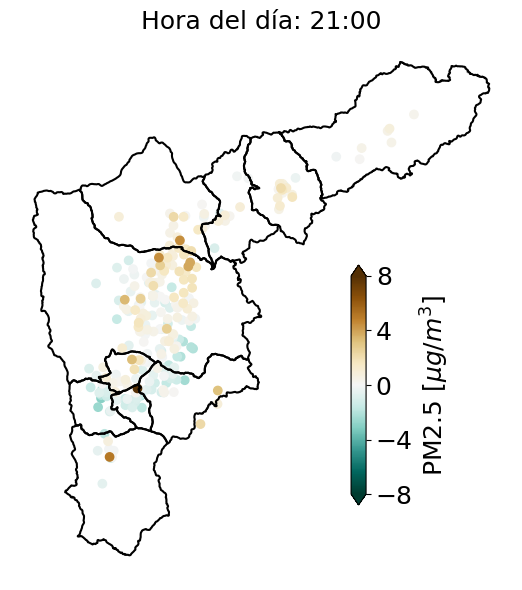

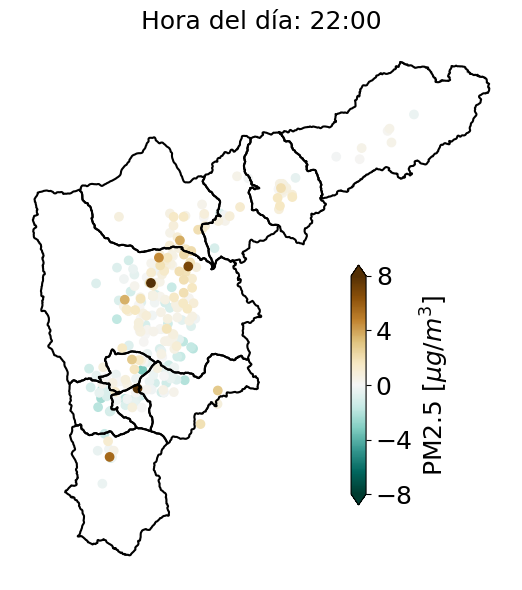

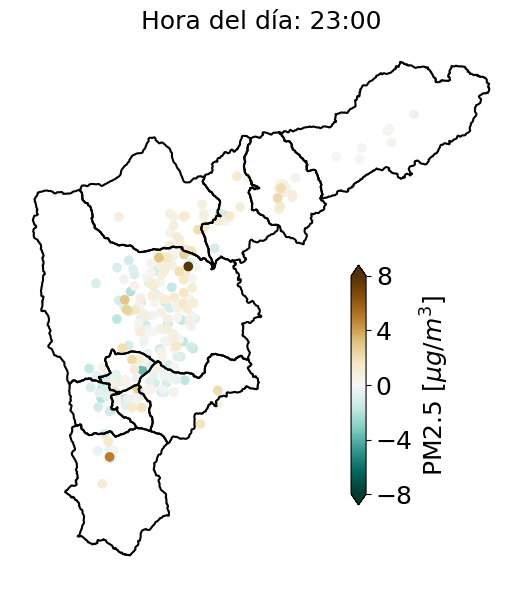

In [15]:
maps(df_anml=hourly_annm)

In [16]:
creating_animation(pathname='./figures/maps/CD_*.png', textsave='CD_PM25_animacion')

### Annual cycles

In [17]:
df_ncc_pm25_promD = df_ncc_pm25.resample('1d').mean()
count             = df_ncc_pm25.resample('1d').count()
df_ncc_pm25_promD[count < 18] = np.nan

df_ncc_pm25_promM = df_ncc_pm25_promD.resample('1MS').mean()
count             = df_ncc_pm25_promD.resample('1MS').count()
df_ncc_pm25_promM[count < 21] = np.nan

df_ncc_pm25_promM['month'] = df_ncc_pm25_promM.index.month
HAC = df_ncc_pm25_promM.groupby(by='month').mean()

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

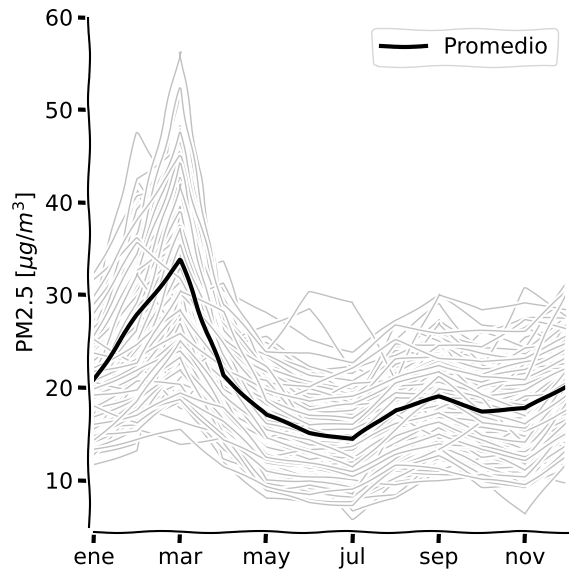

In [18]:
with plt.xkcd():

    fig, ax = plt.subplots(facecolor='w', figsize=(6, 6))

    ax.plot(HAC, color='silver', linewidth=1.)
    ax.plot(HAC.mean(axis=1), color='k', linewidth=3., label='Promedio')

    ax.set_xticks(range(1, 13, 2))
    ax.set_xticklabels([month_abbr[m] for m in range(1, 13, 2)])

    ax.set_xlim(1, 12)
    ax.set_ylim(5, 60)

    ax.set_ylabel(r'PM2.5 [$\mu g/m^3$]', fontsize=16)

    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('k')
    ax.tick_params(axis='both', which='both', colors='k', labelsize=16)

    ax.spines.bottom.set_position(('axes', -.01))
    ax.spines.left.set_position(('axes', -.01))

    ax.legend(fontsize=16)

    fig.tight_layout()

#### Maps

In [19]:
monthly_annm = HAC - HAC.mean()

/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3234300/2168590812.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so

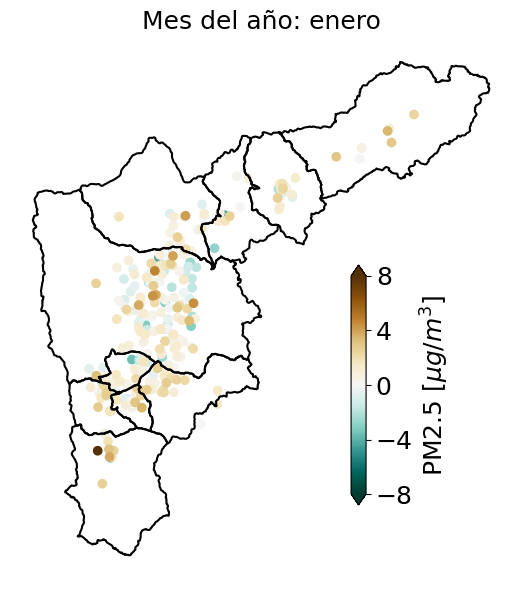

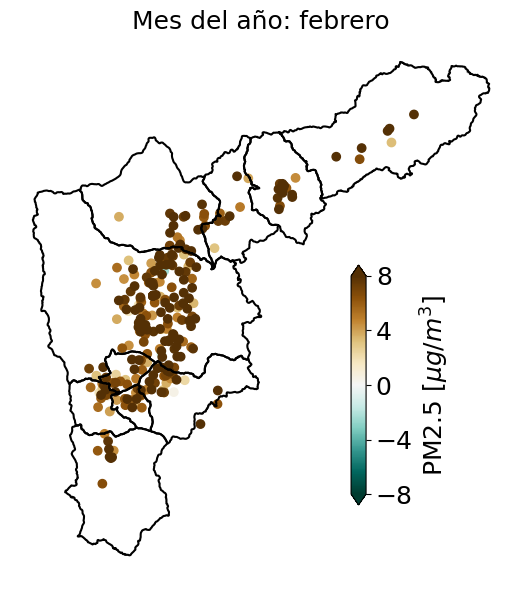

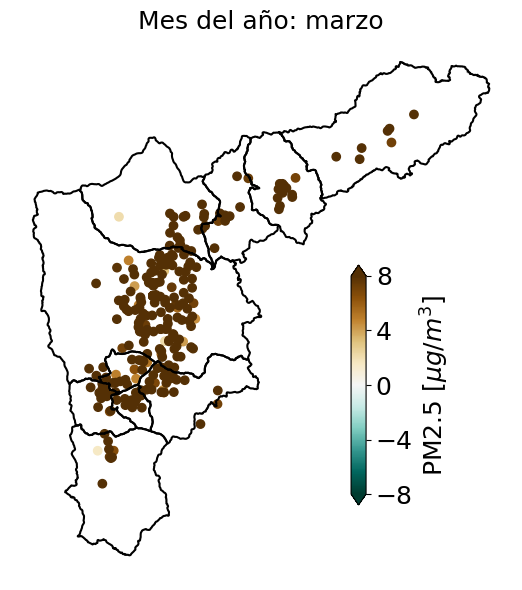

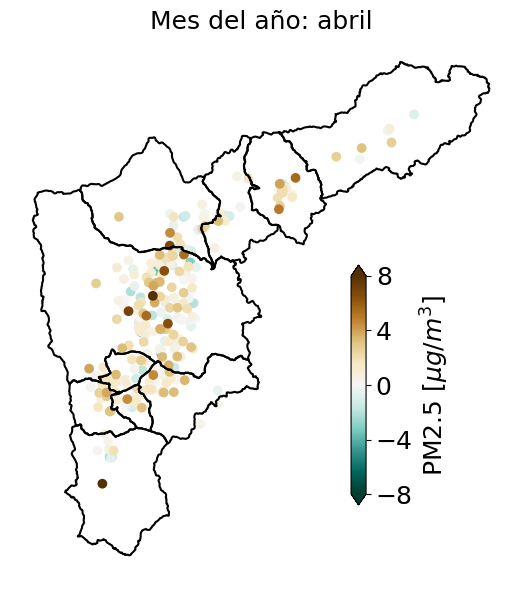

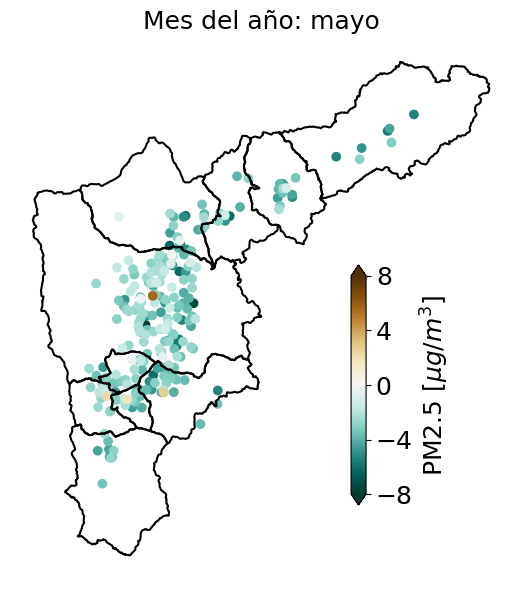

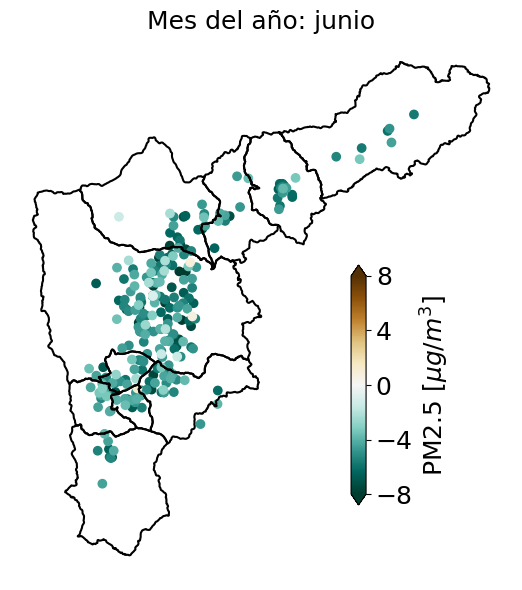

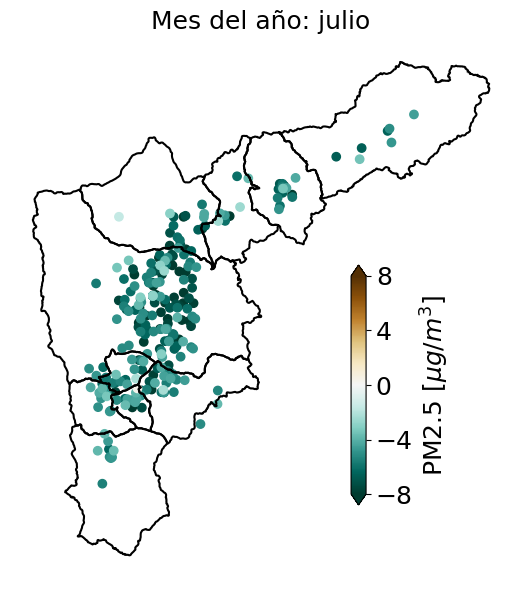

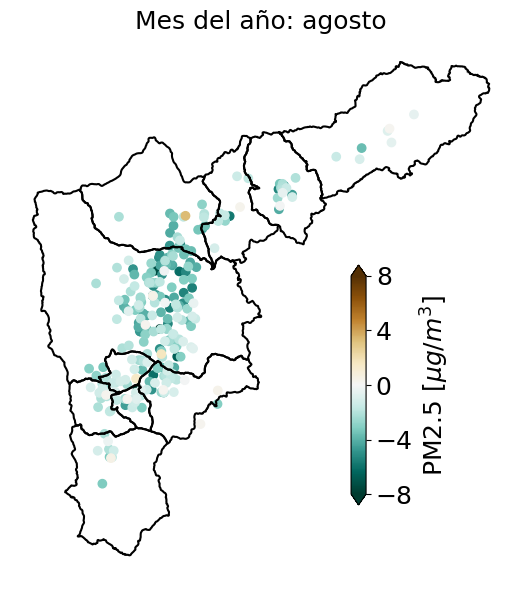

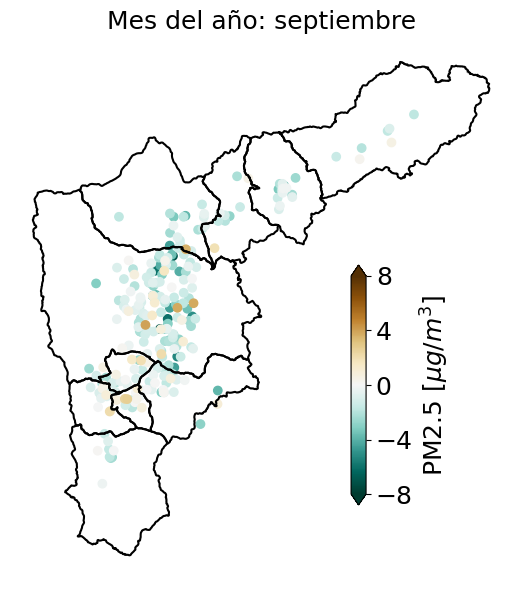

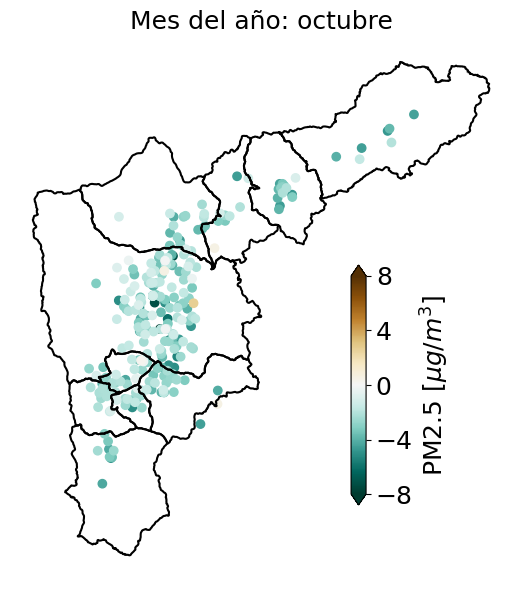

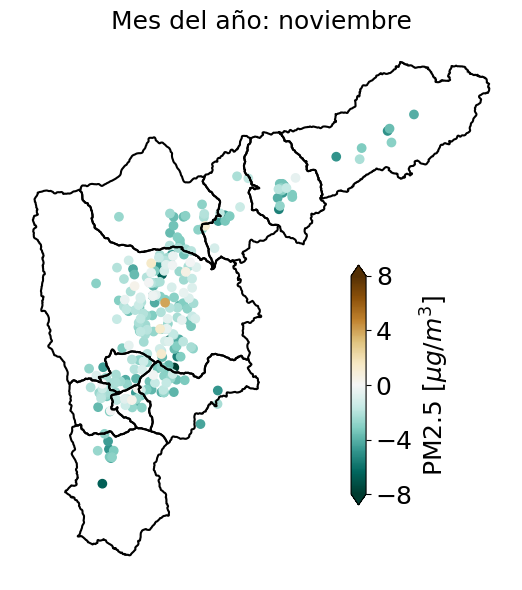

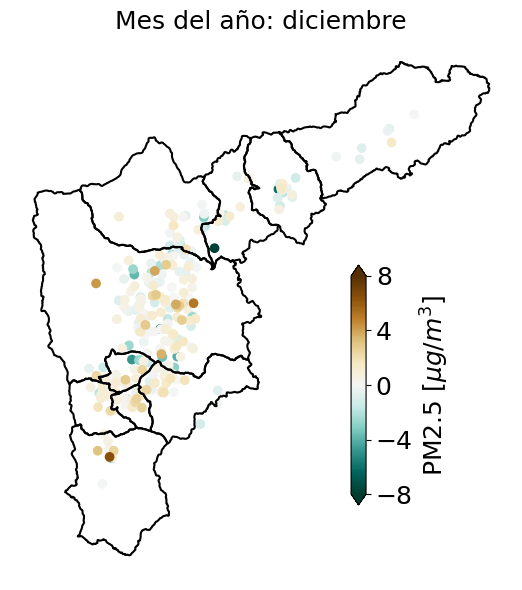

In [20]:
maps(df_anml=monthly_annm, CD=False)

In [21]:
creating_animation(pathname='./figures/maps/CA_*.png', textsave='CA_PM25_animacion')

## Metro users

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from calendar import month_abbr
from locale import setlocale, LC_TIME

setlocale(LC_TIME, 'es_CO.UTF-8')

'es_CO.UTF-8'

In [ ]:
dir_csv_metro_users = './csv/clean_data/Hourly_TS_metro_users.csv'

df_metro_users = pd.read_csv(dir_csv_metro_users, index_col=[0], parse_dates=[0])
df_metro_users.rename(columns={'0': 'users'}, inplace=True)

users
2019-01-01 04:00:00    35.0
2019-01-01 05:00:00  6390.0
2019-01-01 06:00:00  8174.0
2019-01-01 07:00:00  7025.0
2019-01-01 08:00:00  6675.0

### Diurnal Cycle

In [10]:
df_metro_users['hour'] = df_metro_users.index.hour
CD_metro_users = df_metro_users.groupby(by='hour').describe()

df_metro_users.drop(columns='hour', inplace=True)

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not fou

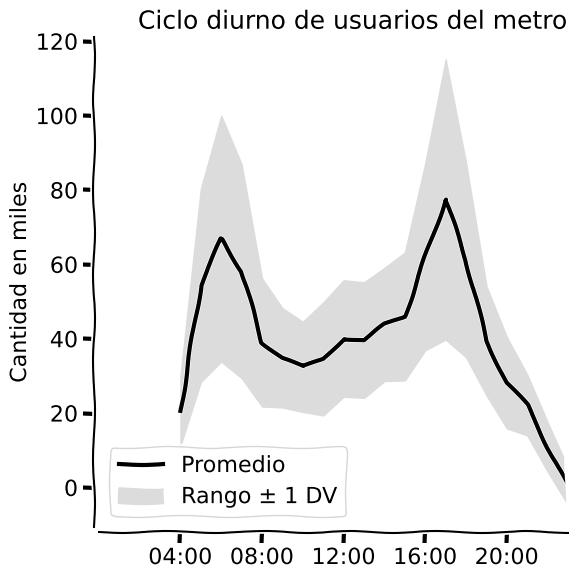

In [47]:
with plt.xkcd():
    fig, ax = plt.subplots(facecolor='w', figsize=(6, 6))

    ax.plot(CD_metro_users[('users', 'mean')]/1e3, color='k', linewidth=3., label='Promedio')
    ax.fill_between(
        x=CD_metro_users.index,
        y1=(CD_metro_users[('users', 'mean')] + CD_metro_users[('users', 'std')])/1e3,
        y2=(CD_metro_users[('users', 'mean')] - CD_metro_users[('users', 'std')])/1e3,
        color='gainsboro',
        label='Rango ± 1 DV'
    )

    ax.set_xticks(range(4, 24, 4))
    ax.set_xticklabels([str(h).zfill(2)+':00' for h in range(4, 24, 4)])

    ax.set_xlim(0, 23)
    # ax.set_ylim(5, 40)

    ax.set_ylabel(r'Cantidad en miles', fontsize=16)
    ax.set_title('Ciclo diurno de usuarios del metro', fontsize=18, loc='right')

    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('k')
    ax.tick_params(axis='both', which='both', colors='k', labelsize=16)

    ax.spines.bottom.set_position(('axes', -.01))
    ax.spines.left.set_position(('axes', -.01))

    ax.legend(fontsize=16, loc='lower left')

    fig.tight_layout()

### Annual cycle

In [61]:
df_metro_users_promD = df_metro_users.resample('1D').mean()
df_metro_users_promM = df_metro_users_promD.resample('1MS').mean()

df_metro_users_promM['month'] = df_metro_users_promM.index.month

CA_metro_users = df_metro_users_promM.groupby(by='month').describe()

df_metro_users_promM.loc['2020'] = np.nan
df_metro_users_promM.loc['2021'] = np.nan

CA_metro_users_without_pandemia = df_metro_users_promM.groupby(by='month').describe()

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

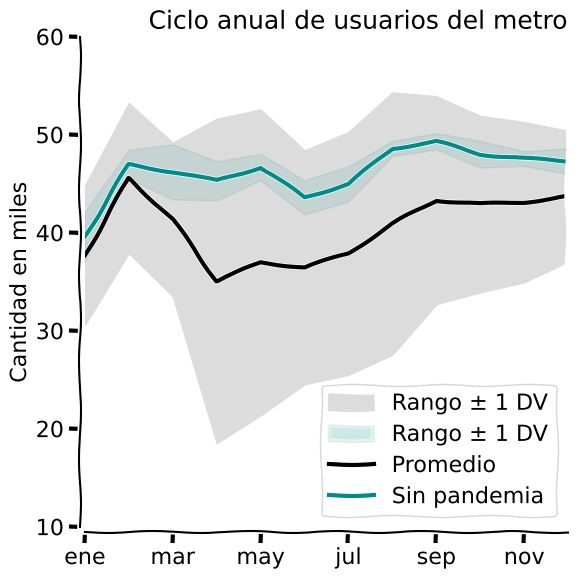

In [64]:
with plt.xkcd():
    fig, ax = plt.subplots(facecolor='w', figsize=(6, 6))

    ax.fill_between(
        x=CA_metro_users.index,
        y1=(CA_metro_users[('users', 'mean')] + CA_metro_users[('users', 'std')])/1e3,
        y2=(CA_metro_users[('users', 'mean')] - CA_metro_users[('users', 'std')])/1e3,
        color='gainsboro',
        label='Rango ± 1 DV'
    )

    ax.fill_between(
        x=CA_metro_users_without_pandemia.index,
        y1=(CA_metro_users_without_pandemia[('users', 'mean')] + CA_metro_users_without_pandemia[('users', 'std')])/1e3,
        y2=(CA_metro_users_without_pandemia[('users', 'mean')] - CA_metro_users_without_pandemia[('users', 'std')])/1e3,
        color='darkcyan',
        label='Rango ± 1 DV',
        alpha=.1
    )
    
    ax.plot(CA_metro_users[('users', 'mean')]/1e3, color='k', linewidth=3., label='Promedio')
    ax.plot(CA_metro_users_without_pandemia[('users', 'mean')]/1e3, color='darkcyan', linewidth=3., label='Sin pandemia')

    ax.set_ylim(10, 60)
    ax.set_xticks(range(1, 13, 2))
    ax.set_xticklabels([month_abbr[m] for m in range(1, 13, 2)])

    ax.set_xlim(1, 12)

    ax.set_ylabel(r'Cantidad en miles', fontsize=16)
    ax.set_title('Ciclo anual de usuarios del metro', fontsize=18, loc='right')

    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('k')
    ax.tick_params(axis='both', which='both', colors='k', labelsize=16)

    ax.spines.bottom.set_position(('axes', -.01))
    ax.spines.left.set_position(('axes', -.01))

    ax.legend(fontsize=16, loc='lower right')

    fig.tight_layout()